In [1]:
# !pip install transformers

In [2]:
import pandas as pd
import numpy as np
# import glob
# import re

# from tokenizers import SentencePieceBPETokenizer, normalizers, decoders
# from tokenizers.normalizers import Replace

# from nltk.tokenize import word_tokenize

from transformers import AutoConfig, AutoModelForCausalLM
from transformers import PreTrainedTokenizerFast
import torch

In [3]:
config = AutoConfig.from_pretrained("openai-community/gpt2")

config.n_head = 6
config.n_layer = 6
config.vocab_size = 32768
config.n_embd = 384
config.n_ctx = 768

model = AutoModelForCausalLM.from_config(config=config)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 23623680


In [4]:
# import zipfile

# # Replace 'path/to/your/file.zip' with your actual zip file path
# with zipfile.ZipFile('Archive 2.zip', 'r') as zip_ref:
#     zip_ref.extractall('train')  # Specify the directory to extract to

In [5]:
X, Y = torch.load('train/X_train.pt'), torch.load("train/Y_train.pt")

In [6]:
X.shape

torch.Size([44789637, 22])

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
model = model.to(device)

In [9]:
X = X[:6398519]
Y = Y[:6398519]

In [10]:
from torch.optim import AdamW
import torch
import numpy as np
import os

# Define the path for saving model checkpoints
checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

optim = AdamW(model.parameters(), lr=0.01)
batch_size = 1024
train_size = len(X)
logging_interval = 0.1
total_loss = 0

perplexity_list = np.array([])
final_loss = np.array([])
steps_per_epochs = len(range(0, train_size, batch_size))
logging_step = int(steps_per_epochs * logging_interval)

for epoch in range(5):
    epoch_loss = np.array([])
    model.train()  # Ensure the model is in training mode

    for idx, iter in enumerate(range(0, train_size, batch_size)):
        x = X[iter: iter + batch_size]
        y = Y[iter: iter + batch_size]
        x, y = x.to(device), y.to(device)

        # Ensure y is a 1D tensor
        y = y.squeeze()

        # Forward pass
        y_pred = model(x)
        loss = torch.nn.functional.cross_entropy(y_pred.logits[:, -1, :], y)

        # Accumulate the loss for logging
        total_loss += loss.item()

        # Zero out gradients, backpropagate, and update weights
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Track epoch loss
        epoch_loss = np.append(epoch_loss, loss.item())

        # Log perplexity at specified intervals
        if idx % logging_step == 0 and idx != 0:
            avg_loss = total_loss / ((iter // batch_size) + 1)
            perplexity = torch.exp(torch.tensor(avg_loss))
            perplexity_list = np.append(perplexity_list, perplexity)
            print(f"Perplexity at epoch {epoch + 1}, step {iter}: {perplexity.item()}")

    # Save checkpoint after each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch + 1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss': epoch_loss.mean()
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

    print(f"Loss of epoch {epoch + 1}: {epoch_loss.mean()}")
    total_loss = 0  # Reset total_loss after each epoch


Perplexity at epoch 1, step 638976: 5127.94580078125
Perplexity at epoch 1, step 1277952: 4184.46923828125
Perplexity at epoch 1, step 1916928: 3767.223876953125
Perplexity at epoch 1, step 2555904: 3658.64208984375
Perplexity at epoch 1, step 3194880: 3458.20263671875
Perplexity at epoch 1, step 3833856: 3287.859130859375
Perplexity at epoch 1, step 4472832: 3117.395263671875
Perplexity at epoch 1, step 5111808: 3039.694091796875
Perplexity at epoch 1, step 5750784: 2946.571533203125
Perplexity at epoch 1, step 6389760: 2859.95166015625
Checkpoint saved at ./model_checkpoints/model_epoch_1.pth
Loss of epoch 1: 7.957959587849852
Perplexity at epoch 2, step 638976: 1914.7987060546875
Perplexity at epoch 2, step 1277952: 1564.8646240234375
Perplexity at epoch 2, step 1916928: 1466.860595703125
Perplexity at epoch 2, step 2555904: 1616.5146484375
Perplexity at epoch 2, step 3194880: 1694.4749755859375
Perplexity at epoch 2, step 3833856: 1776.782958984375
Perplexity at epoch 2, step 44728

/var/folders/jv/6j759gh52pjg5xgj136xc96w0000gn/T/ipykernel_93397/3389737381.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  perplexity_score = torch.load('./perplexity_l

Text(0, 0.5, 'perplexity score')

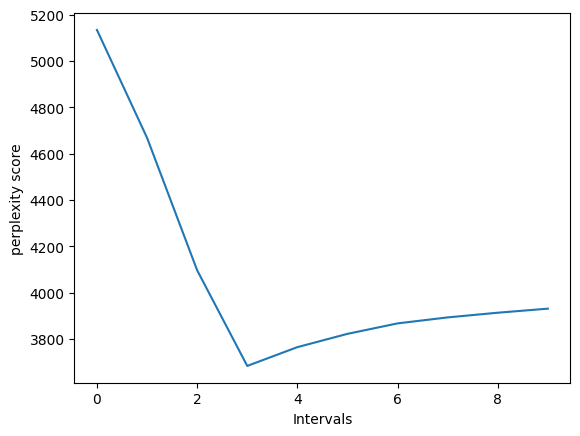

In [10]:
import matplotlib.pyplot as plt

perplexity_score = torch.load('./perplexity_list.pt').numpy()

plt.plot(perplexity_score)
plt.xlabel('Intervals')
plt.ylabel('perplexity score')